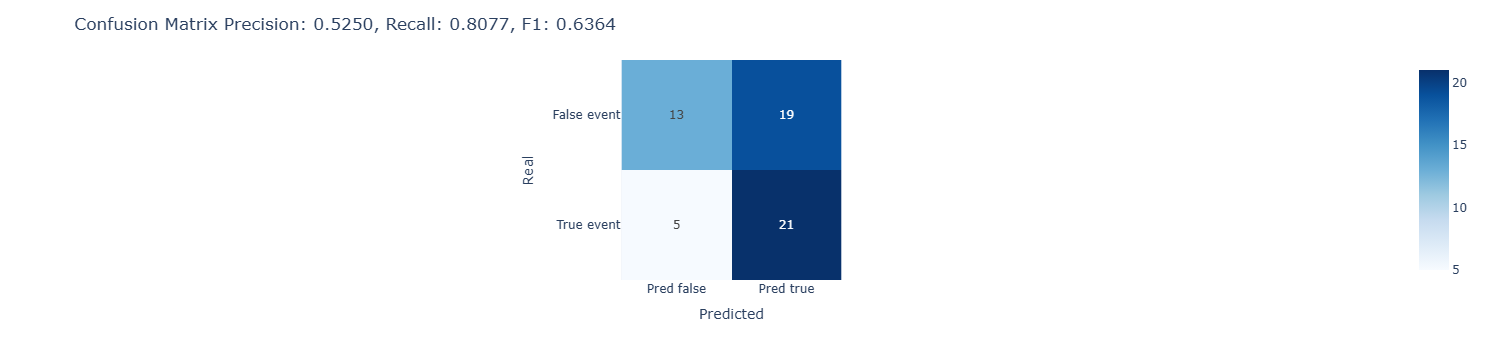

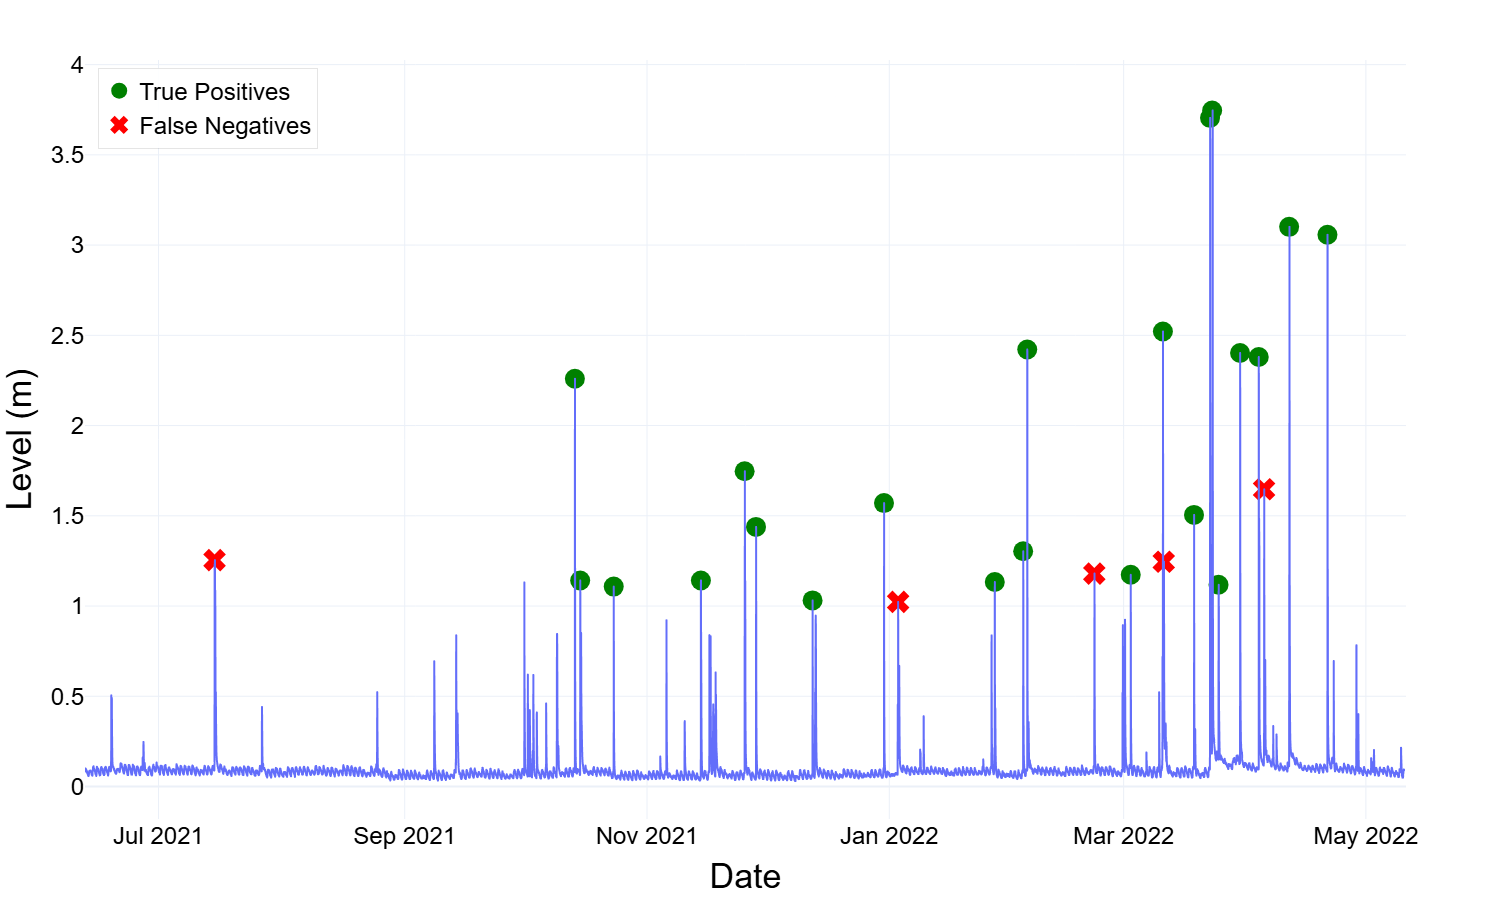

In [16]:
import pandas as pd
import ast
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import plotly.express as px
import plotly.graph_objects as go

# --- carga y preparación de datos ---
data = pd.read_csv('/home/nivelrios/documentos/Mburicao Project/src/data/data_for_clustering_1.csv')
features_f1 = pd.read_csv('/home/nivelrios/documentos/Mburicao Project/src/evaluation/SVM_best_features_f1_1.csv')

df = data.copy().drop(columns=["fecha"])
y = df["event"].astype(int).values

best_features_f1 = features_f1['best_features'].apply(
    lambda x: list(ast.literal_eval(x)) if isinstance(x, str) else list(x)
).tolist()
lista_features_f1 = best_features_f1[4]

K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
model = SVC(kernel='rbf', class_weight='balanced', random_state=42)

# --- evaluación del modelo ---
def evaluate_model(feature_list):
    X = df[feature_list]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    y_pred = cross_val_predict(model, X_scaled, y, cv=skf)
    
    cm = confusion_matrix(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    
    return y_pred, cm, prec, rec, f1

pred, cm, prec_val, rec_val, f1_val = evaluate_model(lista_features_f1)

# --- definir TP y FN ---
results = data[['fecha', 'global_peak']].copy()
results['fecha'] = pd.to_datetime(results['fecha'])
results['event_true'] = y
results['pred'] = pred

tp = results[(results['event_true'] == 1) & (results['pred'] == 1)]
fn = results[(results['event_true'] == 1) & (results['pred'] == 0)]

# --- matriz de confusión ---
cm_df = pd.DataFrame(cm,
                     index=["False event", "True event"],
                     columns=["Pred false", "Pred true"])
title_cm = (f"Confusion Matrix\n"
            f"Precision: {prec_val:.4f}, Recall: {rec_val:.4f}, F1: {f1_val:.4f}")

fig_cm = px.imshow(cm_df, text_auto=True, color_continuous_scale="Blues")
fig_cm.update_layout(
    title=title_cm,
    xaxis_title="Predicted",
    yaxis_title="Real"
)
fig_cm.show()

# --- gráfico de nivel con marcadores TP y FN ---
# carga y formateo de la serie de nivel
df_nivel = pd.read_csv('/home/nivelrios/documentos/Mburicao Project/data/processed/nivel_processed.csv')
df_nivel['fecha'] = pd.to_datetime(df_nivel['fecha'])

# filtrar al rango deseado
start = pd.to_datetime('2021-06-12 12:00:00')
end   = pd.to_datetime('2022-05-10 15:10:00')
df_nivel = df_nivel[(df_nivel['fecha'] >= start) & (df_nivel['fecha'] <= end)]

# dibuja la serie de nivel
fig_level = px.line(
    df_nivel,
    x="fecha",
    y="nivel",
    labels={'fecha': 'Date', 'nivel': 'Level (m)'},
    template='plotly_white'
)
fig_level.update_traces(
    selector=dict(type='scatter', mode='lines'),
    line=dict(color='blue', width=2)
)

# añade True Positives y False Negatives
fig_level.add_trace(go.Scatter(
    x=tp['fecha'],
    y=tp['global_peak'],
    mode='markers',
    name='True Positives',
    marker=dict(color='green', size=20, symbol='circle')
))
fig_level.add_trace(go.Scatter(
    x=fn['fecha'],
    y=fn['global_peak'],
    mode='markers',
    name='False Negatives',
    marker=dict(color='red', size=20, symbol='x')
))

# ajustes de layout
fig_level.update_layout(
    title_font=dict(size=34, color='black', family='Arial'),
    xaxis=dict(
        title='Date',
        title_font=dict(size=34, color='black', family='Arial'),
        tickfont=dict(size=24, family='Arial', color='black')
    ),
    yaxis=dict(
        title='Level (m)',
        title_font=dict(size=34, color='black', family='Arial'),
        tickfont=dict(size=24, family='Arial', color='black')
    ),
    autosize=False,
    width=900,
    height=900,
    legend=dict(
        x=0.01,
        y=0.99,
        bordercolor='rgba(0, 0, 0, 0.1)',
        borderwidth=1,
        bgcolor='rgba(255,255,255,0.9)',
        font=dict(family='Arial', size=24, color='black')
    )
)
fig_level.show()



In [11]:
fecha inicio: 2021-06-12 12:00:00'
fecha fin: '2022-05-10 15:10:00'


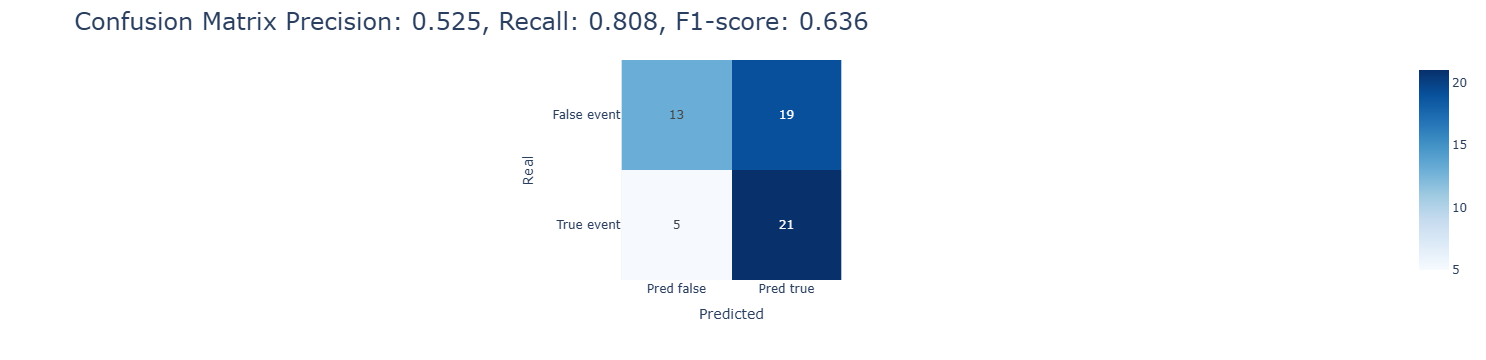

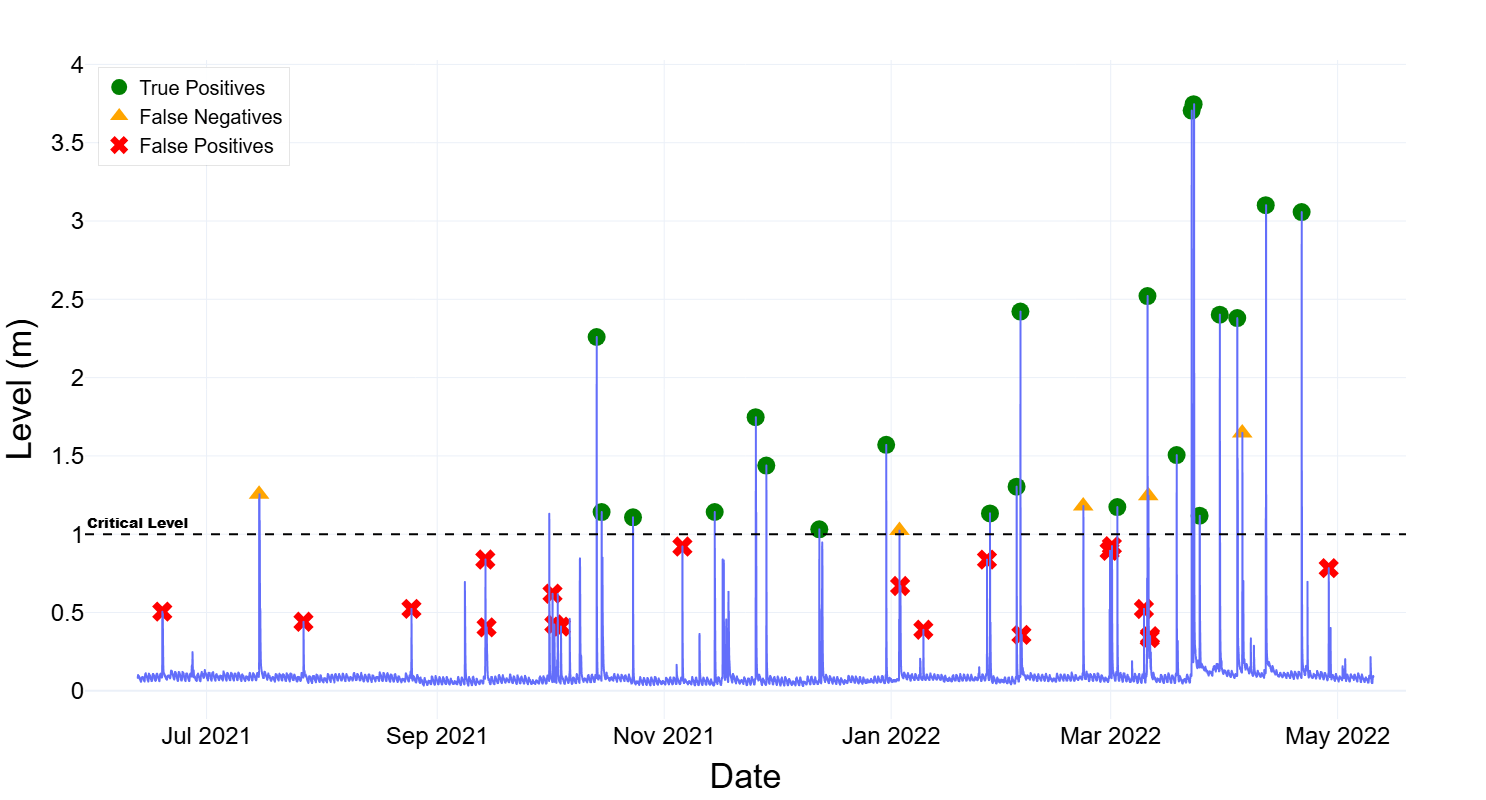

In [25]:
import pandas as pd
import numpy as np
import ast
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
import plotly.express as px
import plotly.graph_objects as go

# --- Carga y preparación de datos ---
data = pd.read_csv('/home/nivelrios/documentos/Mburicao Project/src/data/data_for_clustering_1.csv')
features_f1 = pd.read_csv('/home/nivelrios/documentos/Mburicao Project/src/evaluation/SVM_best_features_f1_1.csv')

df = data.copy().drop(columns=["fecha"])
y = df["event"].astype(int).values

best_features_f1 = features_f1['best_features'].apply(
    lambda x: list(ast.literal_eval(x)) if isinstance(x, str) else list(x)
).tolist()
lista_features_f1 = best_features_f1[4]  # H = 5, i.e., 10-minute horizon

K = 5
skf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)
model = SVC(kernel='rbf', class_weight='balanced', random_state=42)

# --- Evaluación del modelo ---
def evaluate_model(feature_list):
    X = df[feature_list]
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    y_pred = cross_val_predict(model, X_scaled, y, cv=skf)
    
    cm = confusion_matrix(y, y_pred)
    prec = precision_score(y, y_pred)
    rec = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    
    return y_pred, cm, prec, rec, f1

pred, cm, prec_val, rec_val, f1_val = evaluate_model(lista_features_f1)

# --- Definir TP, FN y FP ---
results = data[['fecha', 'global_peak']].copy()
results['fecha'] = pd.to_datetime(results['fecha'])
results['event_true'] = y
results['pred'] = pred

tp = results[(results['event_true'] == 1) & (results['pred'] == 1)]
fn = results[(results['event_true'] == 1) & (results['pred'] == 0)]
fp = results[(results['event_true'] == 0) & (results['pred'] == 1)]

# --- Matriz de confusión ---
cm_df = pd.DataFrame(cm,
                     index=["False event", "True event"],
                     columns=["Pred false", "Pred true"])
title_cm = (f"Confusion Matrix\n"
            f"Precision: {prec_val:.3f}, Recall: {rec_val:.3f}, F1-score: {f1_val:.3f}")

fig_cm = px.imshow(cm_df, text_auto=True, color_continuous_scale="Blues")
fig_cm.update_layout(
    title=title_cm,
    xaxis_title="Predicted",
    yaxis_title="Real",
    title_font=dict(size=24)
)
fig_cm.show()

# --- Serie de nivel con TP, FN y FP ---
df_nivel = pd.read_csv('/home/nivelrios/documentos/Mburicao Project/data/processed/nivel_processed.csv')
df_nivel['fecha'] = pd.to_datetime(df_nivel['fecha'])

start = pd.to_datetime('2021-06-12 12:00:00')
end   = pd.to_datetime('2022-05-10 15:10:00')
df_nivel = df_nivel[(df_nivel['fecha'] >= start) & (df_nivel['fecha'] <= end)]

fig_level = px.line(
    df_nivel,
    x="fecha",
    y="nivel",
    labels={'fecha': 'Date', 'nivel': 'Level (m)'},
    template='plotly_white'
)
fig_level.update_traces(
    selector=dict(type='scatter', mode='lines'),
    line=dict(color='blue', width=2)
)

# Añadir TP (verde)
fig_level.add_trace(go.Scatter(
    x=tp['fecha'],
    y=tp['global_peak'],
    mode='markers',
    name='True Positives',
    marker=dict(color='green', size=18, symbol='circle')
))

# Añadir FN (amarillo)
fig_level.add_trace(go.Scatter(
    x=fn['fecha'],
    y=fn['global_peak'],
    mode='markers',
    name='False Negatives',
    marker=dict(color='orange', size=18, symbol='triangle-up')
))

# Añadir FP (rojo)
fig_level.add_trace(go.Scatter(
    x=fp['fecha'],
    y=fp['global_peak'],
    mode='markers',
    name='False Positives',
    marker=dict(color='red', size=18, symbol='x')
))

# Layout
fig_level.update_layout(
   # title="Detected Events Over Level Time Series",
   # title_font=dict(size=28, family='Arial', color='black'),
    xaxis=dict(
        title='Date',
        title_font=dict(size=34, color='black', family='Arial'),
        tickfont=dict(size=24, family='Arial', color='black')
    ),
    yaxis=dict(
        title='Level (m)',
        title_font=dict(size=34, color='black', family='Arial'),
        tickfont=dict(size=24, family='Arial', color='black')
    ),
    autosize=False,
    width=1000,
    height=800,
    legend=dict(
        x=0.01,
        y=0.99,
        bordercolor='rgba(0, 0, 0, 0.1)',
        borderwidth=1,
        bgcolor='rgba(255,255,255,0.9)',
        font=dict(family='Arial', size=20, color='black')
    )
)
critical_level = 1  # ejemplo
fig_level.add_hline(y=critical_level, line_dash="dash", line_color="black",
                    annotation_text="Critical Level", annotation_position="top left",annotation_font=dict(size=14, family="Arial black", color="black"))
fig_level.show()
